# HMI - Face Recognition

**Authors: Brian van den Berg & Diego Brandjes**

Within this Notebook file, a Face Recognition engine was trained and evaluated that works based on Eigenfaces. Only packages from opencv were used in the execution of this excersice as that was the requirement to pass.

To run this file, you will need to perform the following installations:
- pip install opencv-python
- pip install opencv-contrib-python
- pip install numpy
- pip install matplotlib
- pip install scikit-learn

The specific versions that we used during the latest run can be seen under the following code cell.

In [239]:
import sys
import os
import csv
import cv2
import time
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import random
import sklearn
from sklearn.model_selection import train_test_split

print("Version Register:")
print(f'- Python: {sys.version}')
print(f'- CSV: {csv.__version__}')
print(f'- OpenCV: {cv2.__version__}')
print(f'- Numpy: {np.__version__}')
print(f'- Matplotlib: {matplotlib.__version__}')
print(f'- Scikit-learn: {sklearn.__version__}')

Version Register:
- Python: 3.11.7 (tags/v3.11.7:fa7a6f2, Dec  4 2023, 19:24:49) [MSC v.1937 64 bit (AMD64)]
- CSV: 1.0
- OpenCV: 4.8.1
- Numpy: 1.26.2
- Matplotlib: 3.8.2
- Scikit-learn: 1.3.2


## Load in the Training Data

In [240]:
EIGENFACE_TRAINING_DATA = 'input\\eigenfaces\\eigenfaces.csv'

# Initialize an empty Feature and Label list
X = []
Y = []

# Read the CSV file and collect rows
with open(EIGENFACE_TRAINING_DATA, 'r') as csv_file:
    csv_reader = csv.reader(csv_file)

    # Skip the header row
    _ = next(csv_reader)

    # Read and append each row to the list
    for row in csv_reader:
        X.append(cv2.imread(row[0], cv2.IMREAD_GRAYSCALE))
        Y.append(int(row[1]))

# Convert the list of features and labels to numpy arrays
X = np.array(X)
Y = np.array(Y)

# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=round(time.time()))

# Print the shapes
print('Original Data Shapes:')
print(f'- Features: {X_train.shape}')
print(f'- Labels: {Y_train.shape}')

Original Data Shapes:
- Features: (18, 142, 152)
- Labels: (18,)


## Display Samples

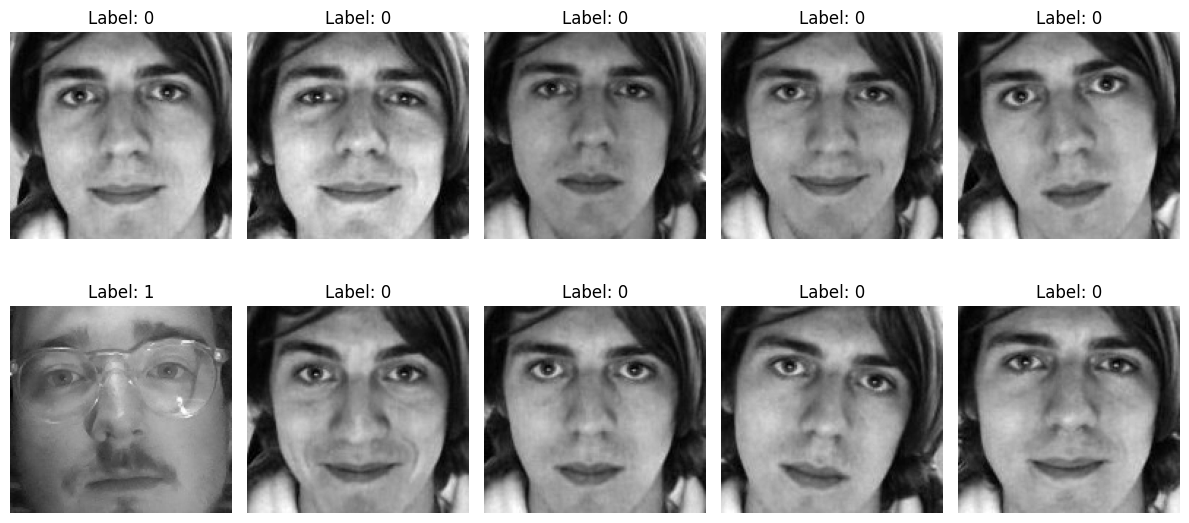

In [241]:
def display_random_samples(X, Y, num_samples=10, num_cols=5, num_rows=1, figsize=(12, 6)):
    if num_samples > len(X):
        num_samples = len(X)
    selected_indices = random.sample(range(X.shape[0]), num_samples)

    # Manage the sub-plots
    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize)

    # Ensure axes is a 2D array, even for a single row
    if num_rows == 1:
        axes = np.expand_dims(axes, axis=0)

    # Display the random samples in the sub-plots
    for i, idx in enumerate(selected_indices):
        row_idx = i // num_cols
        col_idx = i % num_cols
        axes[row_idx, col_idx].imshow(X[idx], cmap='gray')
        axes[row_idx, col_idx].axis('off')
        axes[row_idx, col_idx].set_title(f'Label: {Y[idx]}')
    
    # Hide empty sub-plots
    for i in range(num_samples, num_rows * num_cols):
        row_idx = i // num_cols
        col_idx = i % num_cols
        fig.delaxes(axes[row_idx, col_idx])

    # Adjust layout
    plt.tight_layout()
    plt.show()
    
def display_all_in_order(X, num_cols=5, figsize=(12, 6)):
    num_images = X.shape[0]
    
    # Manage the sub-plots
    num_rows = int(np.ceil(num_images / num_cols))
    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize)

    # Display all images in order in the sub-plots
    for i in range(num_images):
        row_idx = i // num_cols
        col_idx = i % num_cols
        axes[row_idx, col_idx].imshow(X[i], cmap='gray')
        axes[row_idx, col_idx].axis('off')

    # Hide empty sub-plots
    for i in range(num_images, num_rows * num_cols):
        row_idx = i // num_cols
        col_idx = i % num_cols
        fig.delaxes(axes[row_idx, col_idx])

    # Adjust layout
    plt.tight_layout()
    plt.show()

def display_single_image(image, cmap='gray'):
    plt.imshow(image, cmap=cmap)
    plt.axis('off')
    plt.show()

# Show 10 random samples
display_random_samples(X_train, Y_train, num_samples=10, num_cols=5, num_rows=2, figsize=(12, 6))

## Reshape the Features

In [242]:
windowShape = X_train[0].shape
X_train_flattened = np.array([image.reshape(-1) for image in X_train])

print('Transformed Data:')
print(f'- Original Shape: {windowShape}')
print(f'- New Shape: {X_train_flattened[0].shape}')

Transformed Data:
- Original Shape: (142, 152)
- New Shape: (21584,)


## Calculate the Average Face

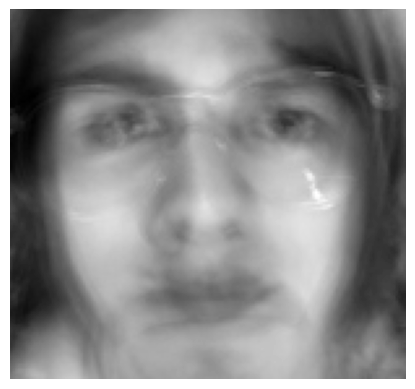

In [243]:
weight = 1 / len(X_train_flattened)
mean = np.zeros(len(X_train_flattened[0]))
for x in X_train_flattened:
    mean += (weight * x)

display_single_image(mean.reshape(windowShape))

## Normalize faces

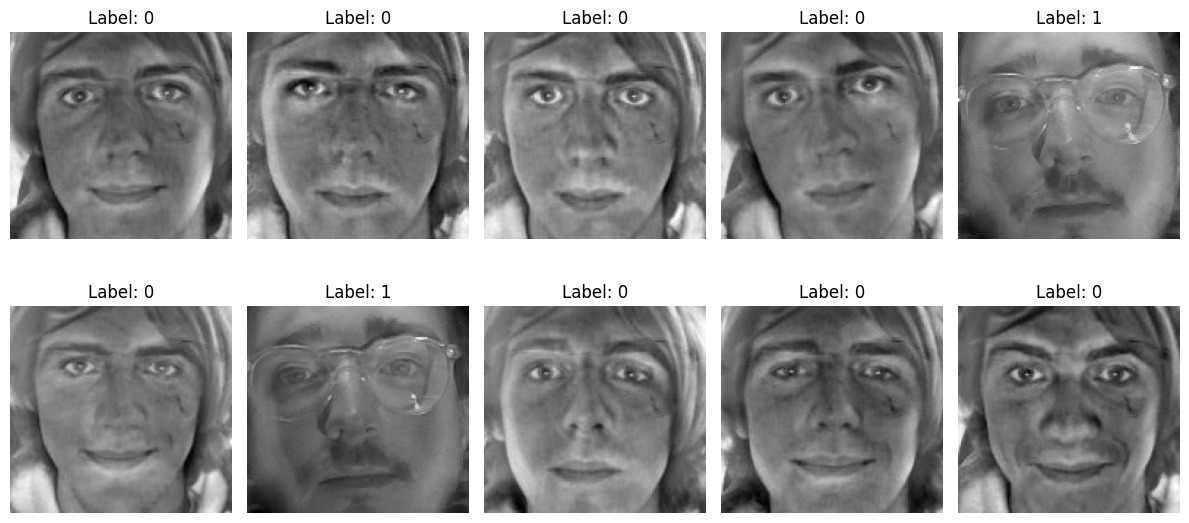

In [244]:
X_train_normalized = X_train_flattened - mean
X_viewable = np.array([image.reshape(windowShape) for image in X_train_normalized])

# Show 10 random samples
display_random_samples(X_viewable, Y_train, num_samples=10, num_cols=5, num_rows=2, figsize=(12, 6))

## Calculate Eigenvectors

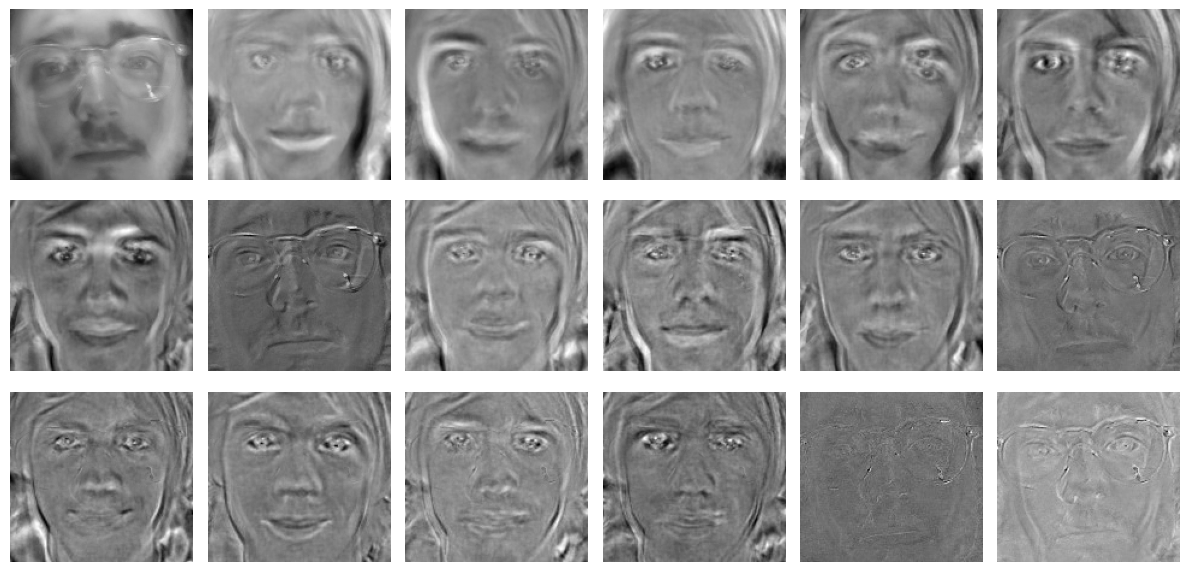

In [245]:
# Calculate the eigenvectors
_, eigenvectors = cv2.PCACompute(X_train_normalized, mean=None)

# Take the 40 best eigenfaces
best_eigenfaces = []
for eigenface in eigenvectors[0 : 40]:
   best_eigenfaces.append(eigenface)
best_eigenfaces = np.array(best_eigenfaces)

# Display the eigenvectors
best_eigenfaces_viewable = np.array([image.reshape(windowShape) for image in best_eigenfaces])
display_all_in_order(best_eigenfaces_viewable, 6)

## Make an Eigenface Recognizer

In [246]:
# Create an EigenFace Recognizer
recognizer = cv2.face.EigenFaceRecognizer().create()

# Project training data onto the eigenface subspace
X_train_projected = np.dot(X_train_normalized, best_eigenfaces.T)

# Train the recognizer with the projected training data and labels
recognizer.train(X_train_projected, Y_train)

## Perform Predictions on the Test Data

Predictions made by the Algorithm:


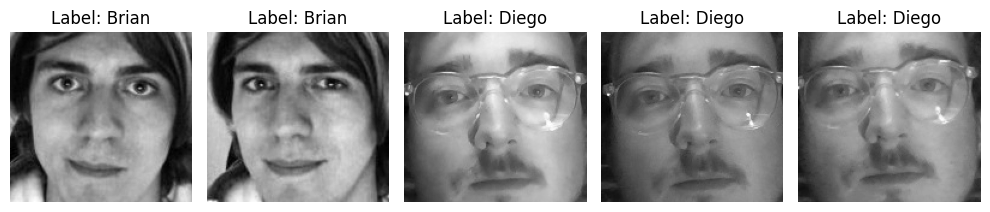

In [247]:
# Initialize a list to store the predicted labels
Y_pred = []

# Iterate through each test face
for face in X_test:
    # Preprocess the Test Face
    face_flat = face.reshape(-1)
    face_normalized = face_flat - mean
    face_projected = np.dot(face_normalized, best_eigenfaces.T)

    # Recognize the face using the trained recognizer
    label, confidence = recognizer.predict(face_projected)

    # Store the predicted label
    Y_pred.append(label)

# Convert the list of predicted labels to a numpy array
Y_pred = np.array(Y_pred)

# Create a dictionary to map numeric labels to names
label_mapping = {0: 'Brian', 1: 'Diego'}

# Map the numeric labels to names
Y_pred_names = np.vectorize(label_mapping.get)(Y_pred)

# Display random samples with predicted labels
print("Predictions made by the Algorithm:")
display_random_samples(X_test, Y_pred_names, num_samples=40, num_cols=5, num_rows=8, figsize=(10, 16))

## Save the Model and Eigenfaces

In [248]:
os.makedirs('models', exist_ok=True)

# Save best_eigenfaces
np.save(os.path.join('models', 'best_eigenfaces.npy'), best_eigenfaces)

# Save mean face
np.save(os.path.join('models', 'mean_face.npy'), mean)

# Save EigenFaceRecognizer
recognizer.save(os.path.join('models', 'eigenface_recognizer.yml'))